# Vector quantization and classification

## Problems
Total points: 100

Obtain the actitivities of daily life dataset from the UC Irvine machine learning website (https://archive.ics.uci.edu/ml/datasets/Dataset+for+ADL+Recognition+with+Wrist-worn+Accelerometer, data provided by Barbara Bruno, Fulvio Mastrogiovanni and Antonio Sgorbissa). Ignore the directories with MODEL in the name. They are duplicates.

(a) Build a classifier that classifies sequences into one of the 14 activities provided and evaluate its performance using average accuracy over 3 fold cross validation. To do the cross validation, divide the data for each class into 3 folds separately. Then, for a given run you will select 2 folds from each class for training and use the remaining fold from each class for test. To make features, you should vector quantize, then use a histogram of cluster center. This method is described in great detail in the book in section 9.3 which begins on page 166. You will find it helpful to use hierarchical k-means to vector quantize. You may perform the vector quantization for the entire dataset before doing cross validation.

You may use whatever multi-class classifier you wish, though we'd suggest you use a decision forest because it's easy to use and effective.

You should report (i) the average error rate over 3 fold cross validation and (ii) the class confusion matrix of your classifier for the fold with the lowest error, i.e. just one matrix for the 3 folds.

(b) Now see if you can improve your classifier by (i) modifying the number of cluster centers in your hierarchical k-means and (ii) modifying the size of the fixed length samples that you see.

In [54]:
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import os
import math
import time

In [57]:
def getData(act_dir, filenames):
    data = [np.genfromtxt(act_dir + '/' + filenames[i]) for i in range(len(filenames))]
    return data

# Chop up data into chunks with specified overlap and size

def prepDataKM(data, siz=64, overlap=0):
    
#     Iterate over all activities

    for i in range(len(data)):
        
#         Iterate over all files

        for j in range(len(data[i])):
        
#         Ravel file and turn it into [1,rav.size] numpy array

            rav = np.asarray([np.ravel(data[i][j])])
    
#             If size of ravelled data is not divisible by size of chunks, 
#             collect the leftover data by taking the last 32 rows of data from the back

            if rav.size%(siz*3) != 0:
                ind = math.floor((rav.size-siz*3*overlap)/((1-overlap)*3*siz))
                t = np.asarray([np.asarray(rav[0,int(i*siz*3*(1-overlap)):int(siz*3*(1+i*(1-overlap)))]) for i in range(ind)])
                t = np.concatenate((t,[rav[0,-siz*3:]]))
                if i==0 and j==0:
                    chunks = t.copy()
                else:
                    chunks = np.concatenate((chunks,t))
            else:
                ind = math.floor((rav.size-siz*3*overlap)/((1-overlap)*3*siz))
                t = np.asarray([np.asarray(rav[0,int(i*siz*3*(1-overlap)):int(siz*3*(1+i*(1-overlap)))]) for i in range(ind)])
                if i==0 and j==0:
                    chunks = t.copy()
                else:
                    chunks = np.concatenate((chunks,t))
    return chunks

# Returns k-means centers based on input data and number of clusters

def kmeansCluster0(chunks, clusters0):
    kmeans = MiniBatchKMeans(n_clusters = clusters0).fit(chunks)
    centers0 = kmeans.cluster_centers_
    return centers0

# Returns k-means centers AND cluster indices based on input data and number of clusters

def kmeansCluster1(chunks, clusters1):
    kmeans = MiniBatchKMeans(n_clusters = clusters1).fit(chunks)
    ind1 = kmeans.labels_
    return ind1

# Returns cluster centers after 2nd layer k-means.
# kmeansCluster2 takes in the original data set, center indices from 1st layer, and # of clusters in 2nd layer
# Returns ndarray of all centers

def kmeansCluster2(chunks, ind1, clusters2, siz = 64):
    centers2 = np.asarray([kmeansCluster0(chunks[ind1==i], clusters2) for i in range(np.amax(ind1)+1)])
    centers2 = np.ravel(centers2).reshape(int(centers2.size/(siz*3)),(siz*3))
    return centers2

# Hierarchical k-means
def hkmeans(chunks, lay1, lay2, siz = 64):
    ind1 = kmeansCluster1(chunks, clusters1 = lay1)
    centers2 = kmeansCluster2(chunks, ind1, clusters2 = lay2, siz = 64)
    return centers2

# Returns a list (activity) of ndarray (chopped file) 

def prepDataTestTrain(activity, siz=64, overlap=0):    
#     Iterate over all .txt files
    chunks_list = []

    for j in range(len(activity)):

#         Ravel file and turn it into [1,rav.size] numpy array

        rav = np.asarray([np.ravel(activity[j])])

#             If size of ravelled data is not divisible by size of chunks, 
#             collect the leftover data by taking the last 32 rows of data from the back

        if rav.size%(siz*3) != 0:
            ind = math.floor(int((rav.size-siz*3*overlap)/((1-overlap)*3*siz)))
            t = np.asarray([np.asarray(rav[0,int(i*siz*3*(1-overlap)):int(siz*3*(1+i*(1-overlap)))]) for i in range(ind)])
            t = np.concatenate((t,[rav[0,-siz*3:]]))
            chunks_list.append(t)
        else:
            ind = math.floor(int((rav.size-siz*3*overlap)/((1-overlap)*3*siz)))
            t = np.asarray([np.asarray(rav[0,int(i*siz*3*(1-overlap)):int(siz*3*(1+i*(1-overlap)))]) for i in range(ind)])
            chunks_list.append(t)
    return chunks_list

# Combine two training fractions and transform each activity into ndarray with specified size and overlap
# Returns training_list[i][j] accesses activity i file j

def prepTraining(frac1, frac2, siz = 64, overlap = 0):
    training_list = [prepDataTestTrain(frac1[i]+frac2[i], siz, overlap) for i in range(len(frac1))]
    return training_list

# Transform each activity into ndarray with specified size and overlap
# Returns test_list[i][j] accesses activity i file j

def prepTest(frac1, siz = 64, overlap = 0):
    test_list = [prepDataTestTrain(frac1[i], siz, overlap) for i in range(len(frac1))]
    return test_list

# Use Random Forest to obtain VQ for each file
# Returns normalized ndarray for histogram
# ccenters -> (x,y) & act -> (z,y) i.e. they have the same # of features

def randomForestVQ(ccenters, labels, act, tree = 100, depth=300, histogram = True):
#     clf = KNeighborsClassifier(n_neighbors = tree, n_jobs = -1)
    clf = RandomForestClassifier(n_estimators = tree, max_depth = depth, n_jobs=-1)
    clf.fit(ccenters, labels)
    pre = clf.predict(act)
    if histogram:
        VQ = np.histogram(pre, bins = range(np.amax(labels)+2), density = False)
        n_VQ = VQ[0]/np.sum(VQ[0])
        return n_VQ
    else:
        return pre

# Convert from data[j][i] to ndarray in which each row represents a file

def flattenFolders(data):
    flat_labels = []
    for sub in data:
        for items in sub:
            flat_labels.append(items)
    return np.asarray(flat_labels)

# Generate labels from data[j][i] for Random Forest classifier

def generateLabels(trainHist):
    flat_labels = []
    labels = [np.full((len(trainHist[i])), i) for i in range(len(trainHist))]
    for sub in labels:
        for items in sub:
            flat_labels.append(items)
    return np.asarray(flat_labels)

# Generate mean histograms
def meanHistogram(data):
    meanHist = []
    for i in range(len(data)):
        meanH = np.asarray(data[i])
        meanH = np.sum(meanH, axis=0)/meanH.shape[0]
        meanHist.append(meanH)
    return meanHist

def exportHistograms(Hist, act_names):
    for i in range(14):
        fig, ax = plt.subplots()
        plt.bar(range(len(meanHistogram(Hist)[i])),meanHistogram(Hist)[i])
        plt.ylabel('Normalized Frequency')
        plt.xlabel('Cluster Center')
        plt.title(act_names[i])
        plt.savefig(save_path+act_names[i]+'.png', dpi = 300, format='png', transparent=True)
        plt.show()

def exportConfusionMatrix(confusion):
    np.savetxt(save_path+'Confusion Matrix.txt', confusion, fmt='%4d', delimiter=',', newline='\n')

In [58]:
data_cwd = os.getcwd() + '/HMP_Dataset'
act_names = os.listdir(path=data_cwd)

act_dir = [data_cwd + '/' + act_names[i] for i in range(len(act_names))]

filenames = [os.listdir(path=act_dir[i]) for i in range(len(act_dir))]

# data contains all data from the folder HMP_Dataset
# len(data) = 14 objects
# data[i][j] accesses file j of activity i

data = [getData(act_dir[i], filenames[i]) for i in range(len(act_dir))]
labels = act_names

# Each fraction has 1/3 file of each category in it
# frac1[i][j] accesses file j of activity i

frac1 = [data[i][:round(len(data[i])/3)] for i in range(len(data))]
frac2 = [data[i][round(len(data[i])/3):2*round(len(data[i])/3)] for i in range(len(data))]
frac3 = [data[i][2*round(len(data[i])/3):] for i in range(len(data))]

# Creating chunks of data
chunks = prepDataKM(data, 64, 0.5)

# Hierarchical k-means
centers2 = hkmeans(chunks, lay1 = 14, lay2 = 10, siz = 64)

In [59]:
def predict(train1, train2, test, siz=64, overlap=0.5, tree=200, dep=800, ):
    
    start_time = time.time()
    print(siz,'_14,10_',tree,',',dep)
#     Preparing training and testing dataset
    training1 = prepTraining(train1, train2, siz, overlap)
    test1 = prepTest(test, siz, overlap)
    print("Finished Data Preparations...")
    
#     Get training and testing histograms
    labCen2 = range(centers2.shape[0])
    TrainHist1 = [[randomForestVQ(centers2, labCen2, training1[j][i], tree, dep, True) for i in range(len(training1[j]))] for j in range(len(training1))]
    print("Finished Generating Training Histograms...")
    
    TestHist1 = [[randomForestVQ(centers2, labCen2, test1[j][i], tree, dep, True) for i in range(len(test1[j]))] for j in range(len(test1))]
    print("Finished Generating Testing Histograms...")
    
#     Compare with training histogram
    lab = generateLabels(TrainHist1)
    trainRF = flattenFolders(TrainHist1)
    pred = [[np.asarray([randomForestVQ(trainRF, lab, [TestHist1[j][i]], tree, dep, True)]) for i in range(len(TestHist1[j]))] for j in range(len(TestHist1))]
    print("Finished Predicting...")
    
#     Generating a confusion matrix
    a = [np.ravel(pred[i]).reshape(len(pred[i]),14) for i in range(len(pred))]
    confusion = np.asarray([np.sum(a[i], axis=0) for i in range(len(a))])
    
#     Plot confusion matrix
    fig, ax = plt.subplots()
    im = ax.imshow(confusion)

    ax.set_xticks(np.arange(14))
    ax.set_yticks(np.arange(14))

    ax.set_xticklabels(np.arange(14)+1)
    ax.set_yticklabels(np.arange(14)+1)
    fig.show()
    
#     Accuracy
    acc = [confusion[i][i] for i in range(len(confusion))]
    acc_percentage = np.sum(acc)*100/np.sum(confusion)
    print('Accuracy: ', acc_percentage, '%')
    
    print("Executed in --- %s seconds ---" % (time.time() - start_time))
    
#     Export Resutls
    exportHistograms(TrainHist1, act_names)
    exportConfusionMatrix(confusion)
    print("Finished Exporting Files")


64 _14,10_ 200 , 800
Finished Data Preparations...
Finished Generating Training Histograms...
Finished Generating Testing Histograms...
Finished Predicting...
Accuracy:  67.98561151079137 %
Executed in --- 561.47358751297 seconds ---


C:\Users\worawich-win\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


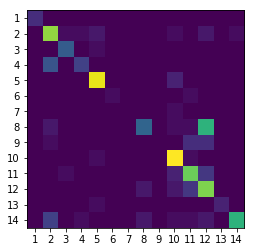

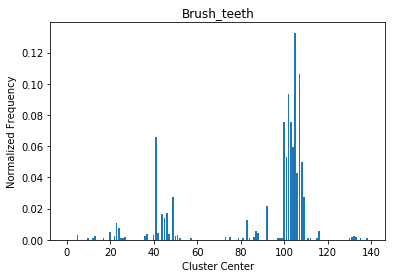

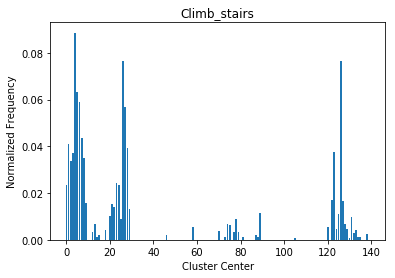

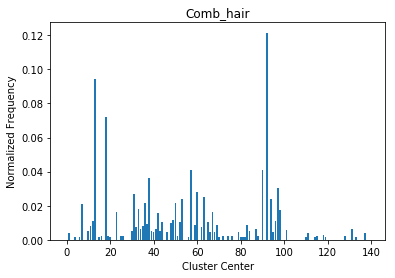

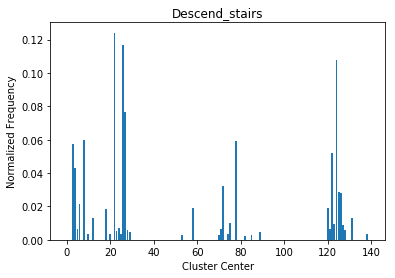

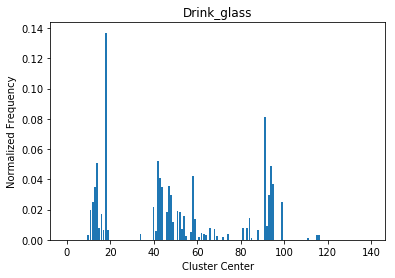

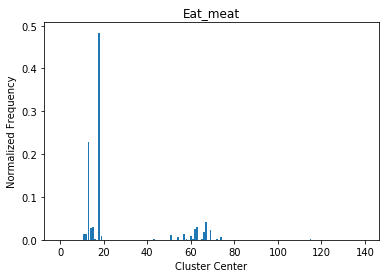

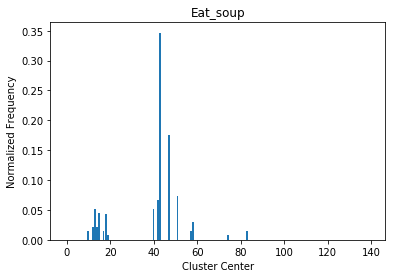

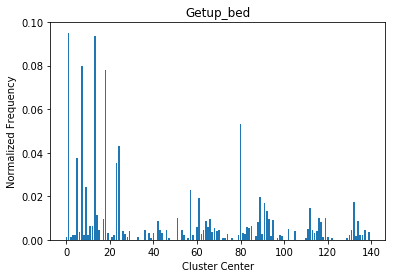

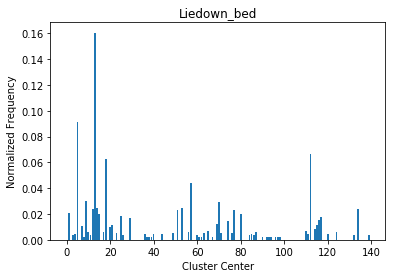

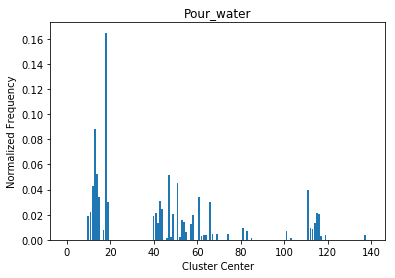

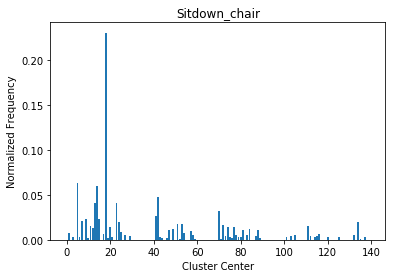

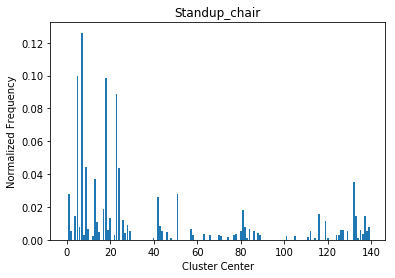

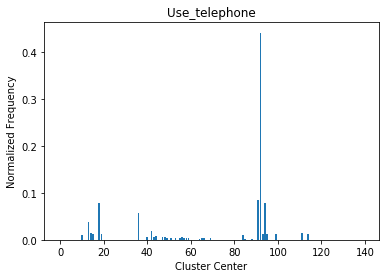

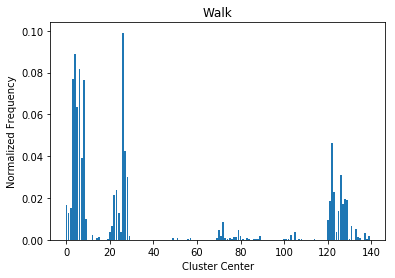

Finished Exporting Files


In [60]:
XvalidSequence = "64_14_10_321_"
save_path = 'C:/Users/worawich-win/Documents/GitHub/CS498AML-HW5/%s' %XvalidSequence
predict(frac3, frac2, frac1)

64 _14,10_ 200 , 800
Finished Data Preparations...
Finished Generating Training Histograms...
Finished Generating Testing Histograms...
Finished Predicting...
Accuracy:  72.79151943462898 %
Executed in --- 563.914541721344 seconds ---


C:\Users\worawich-win\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


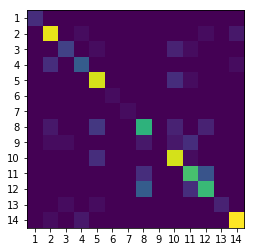

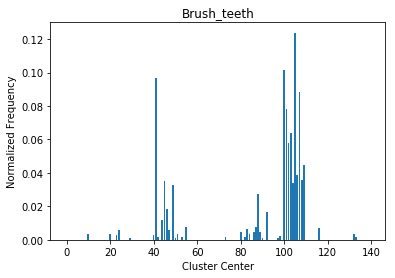

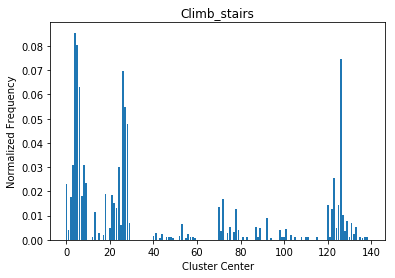

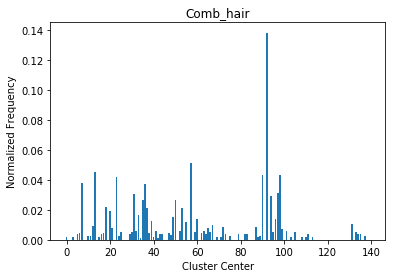

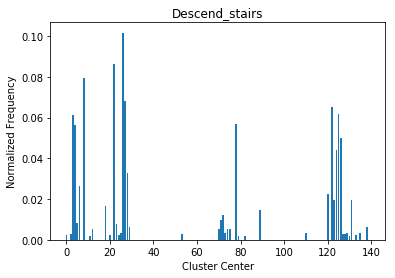

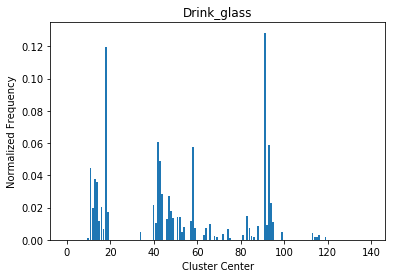

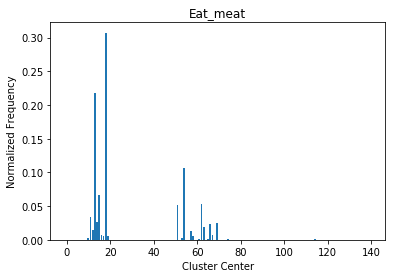

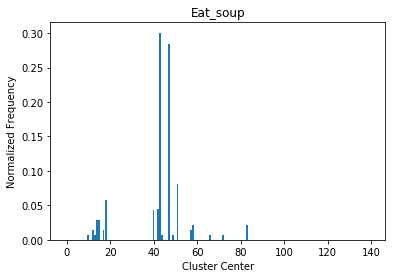

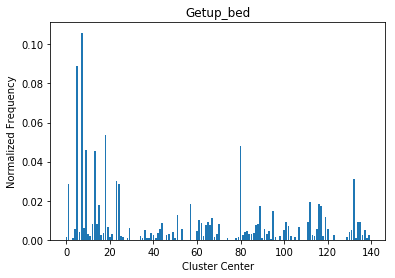

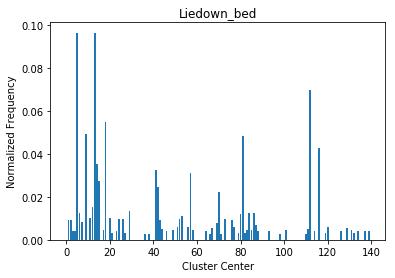

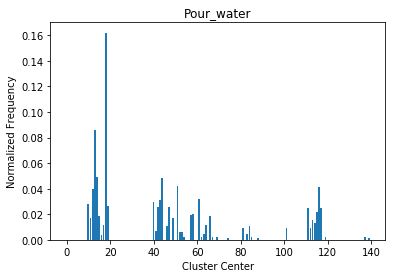

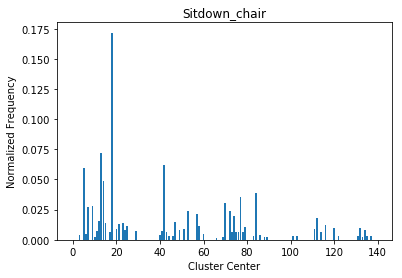

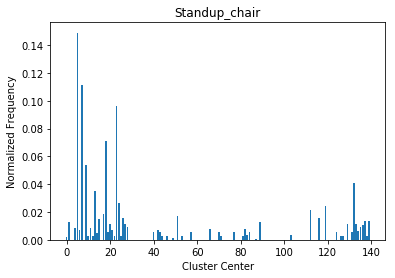

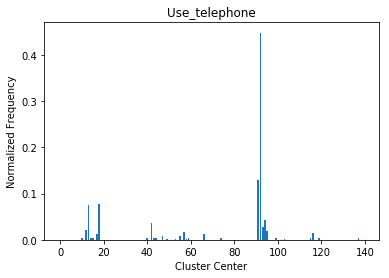

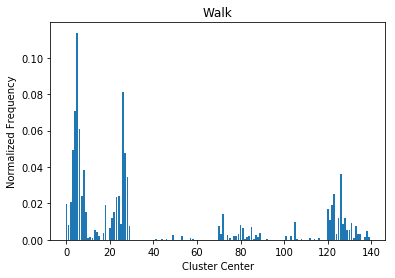

Finished Exporting Files


In [61]:
XvalidSequence = "64_14_10_213_"
save_path = 'C:/Users/worawich-win/Documents/GitHub/CS498AML-HW5/%s' %XvalidSequence
predict(frac2, frac1, frac3)

64 _14,10_ 200 , 800
Finished Data Preparations...
Finished Generating Training Histograms...
Finished Generating Testing Histograms...
Finished Predicting...
Accuracy:  66.18705035971223 %
Executed in --- 559.8339738845825 seconds ---


C:\Users\worawich-win\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


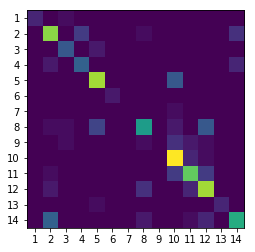

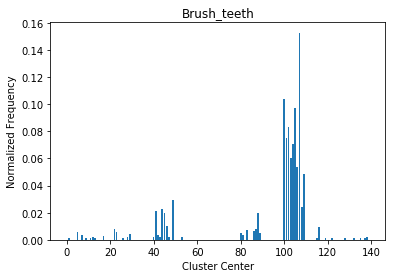

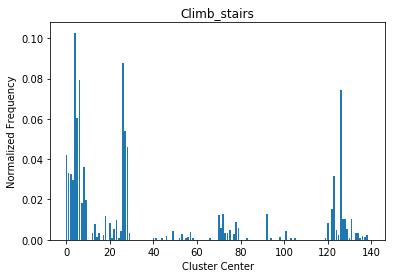

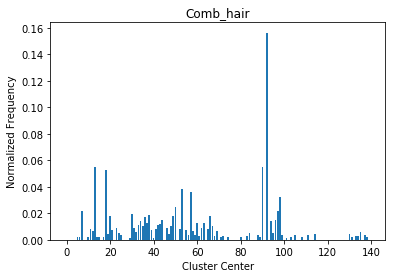

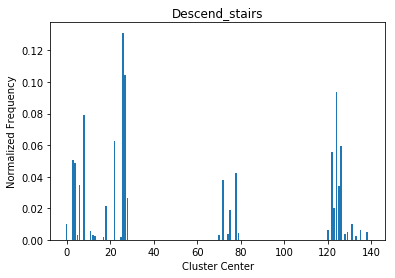

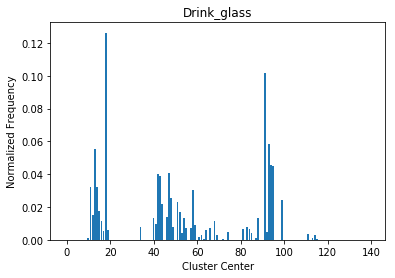

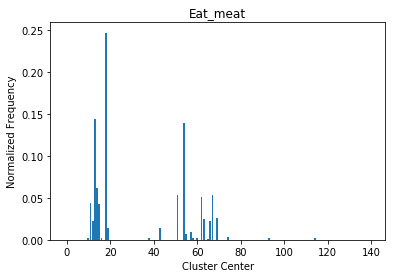

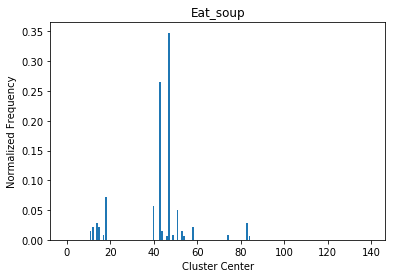

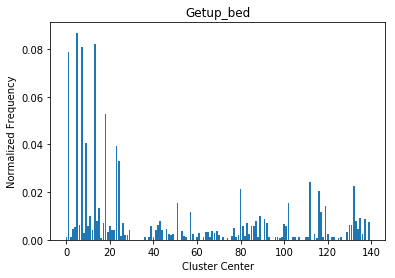

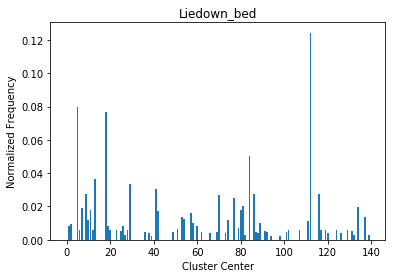

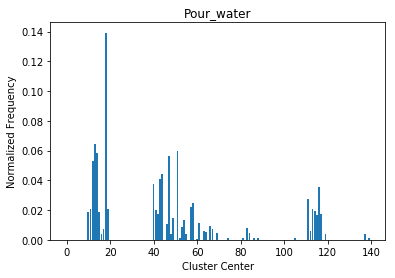

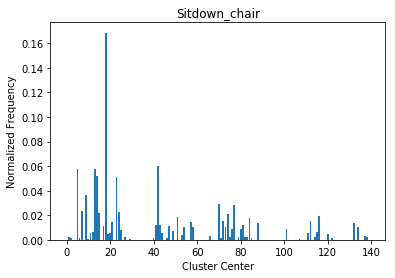

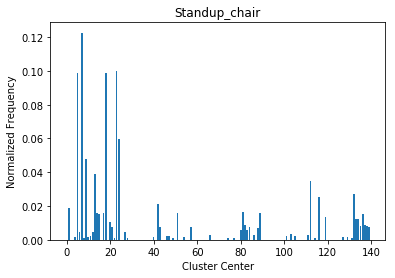

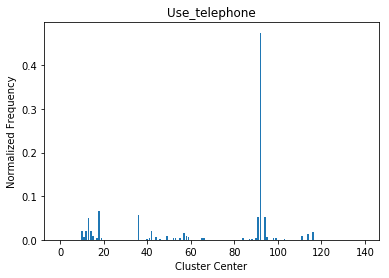

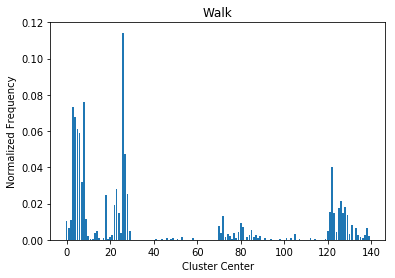

Finished Exporting Files


In [62]:
XvalidSequence = "64_14_10_132_"
save_path = 'C:/Users/worawich-win/Documents/GitHub/CS498AML-HW5/%s' %XvalidSequence
predict(frac1, frac3, frac2)

64 _14,10_ 200 , 800
Finished Data Preparations...
Finished Generating Training Histograms...
Finished Generating Testing Histograms...
Finished Predicting...
Accuracy:  64.02877697841727 %
Executed in --- 1480.3408846855164 seconds ---


C:\Users\worawich-win\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


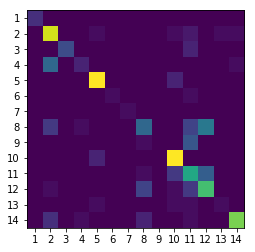

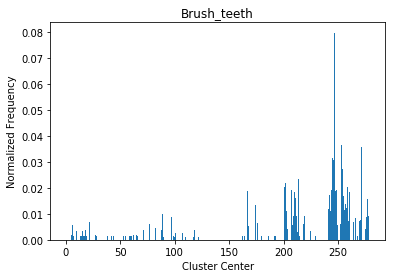

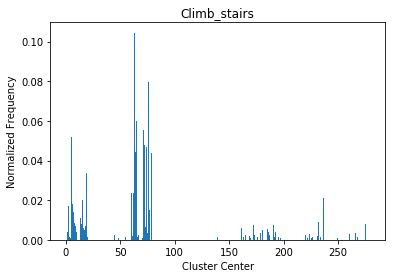

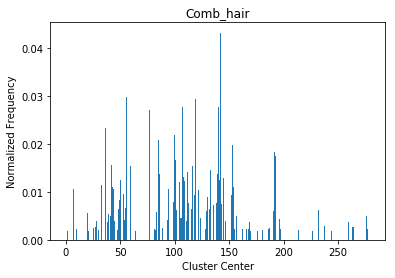

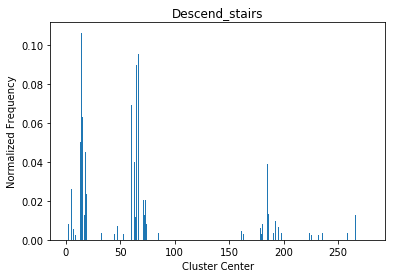

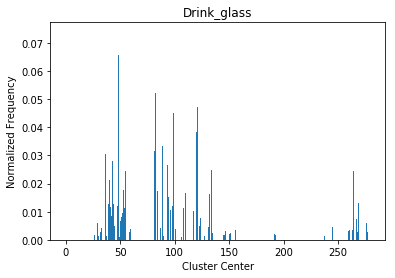

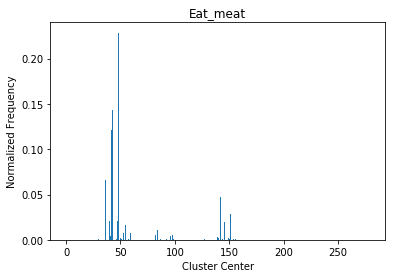

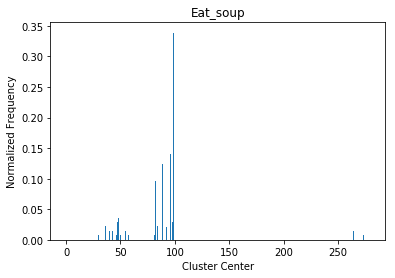

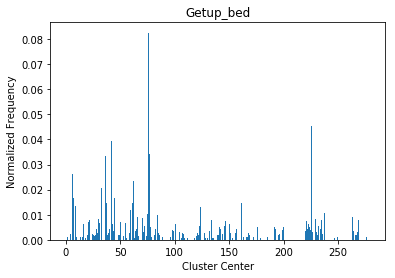

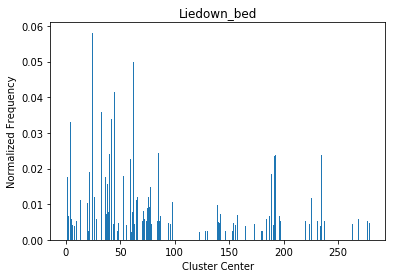

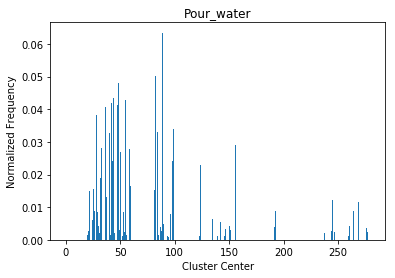

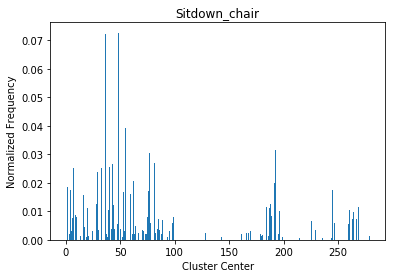

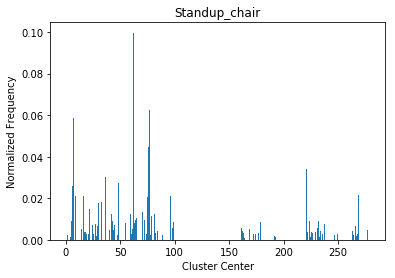

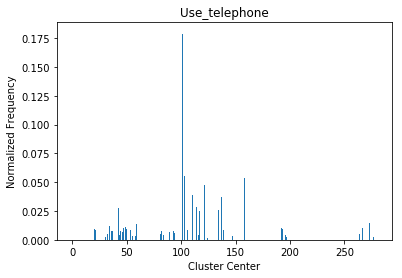

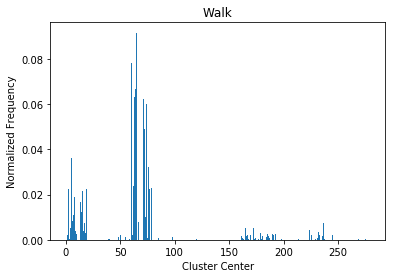

Finished Exporting Files
64 _14,10_ 200 , 800
Finished Data Preparations...
Finished Generating Training Histograms...
Finished Generating Testing Histograms...
Finished Predicting...
Accuracy:  70.6713780918728 %
Executed in --- 1531.01416015625 seconds ---


C:\Users\worawich-win\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


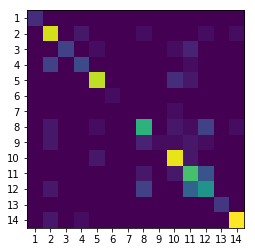

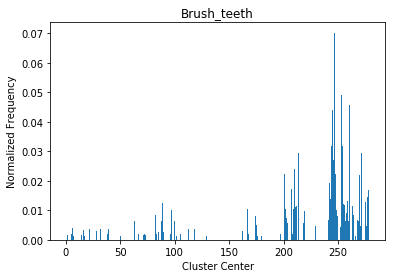

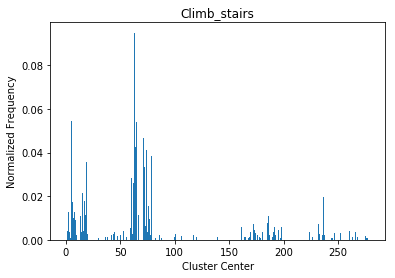

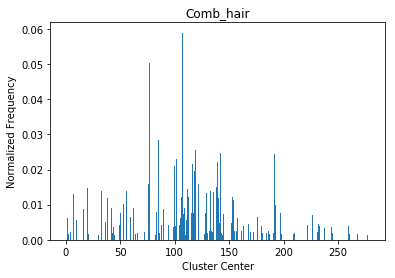

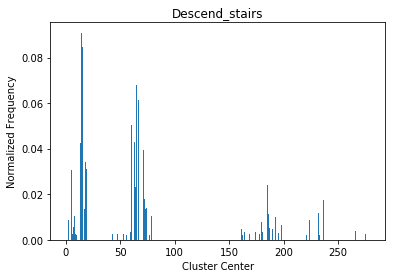

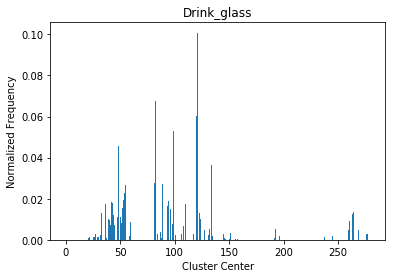

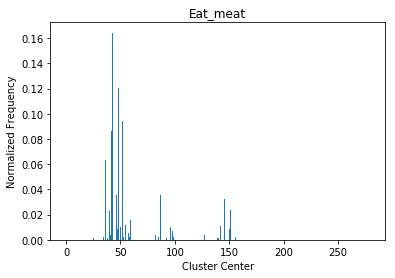

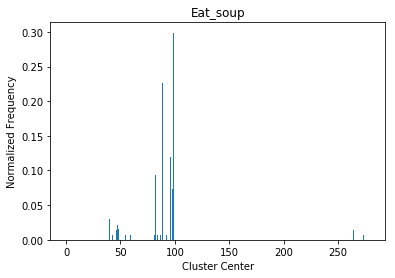

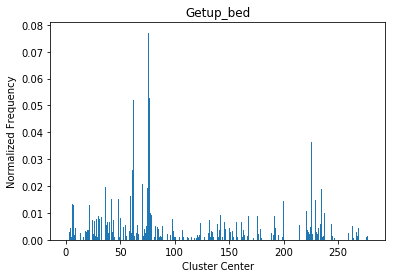

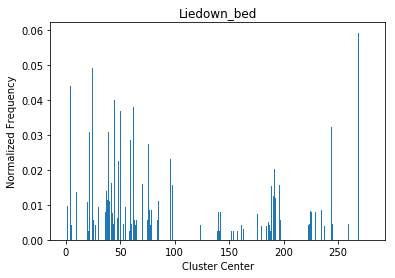

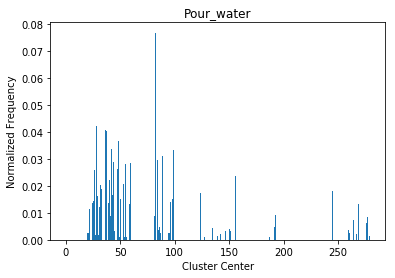

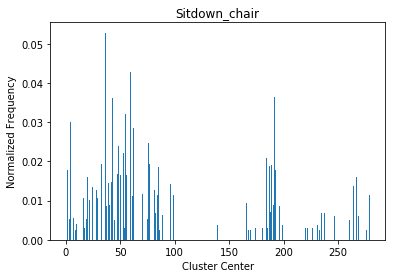

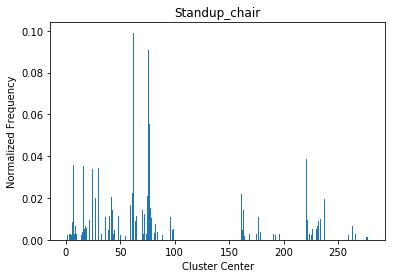

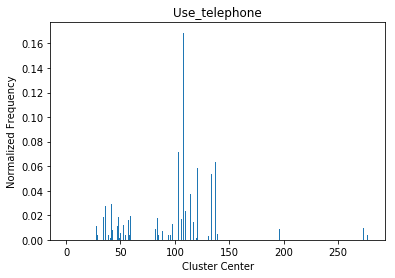

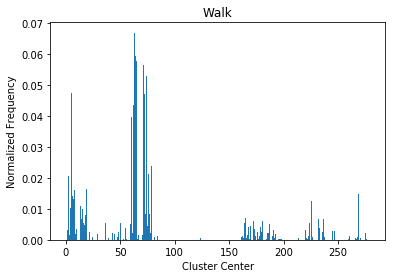

Finished Exporting Files
64 _14,10_ 200 , 800
Finished Data Preparations...
Finished Generating Training Histograms...
Finished Generating Testing Histograms...
Finished Predicting...
Accuracy:  73.02158273381295 %
Executed in --- 1513.5127220153809 seconds ---


C:\Users\worawich-win\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


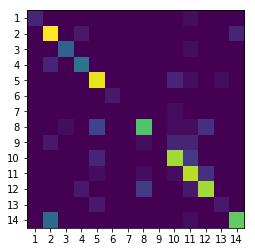

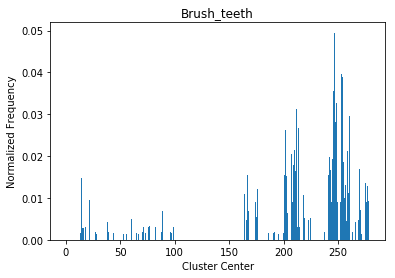

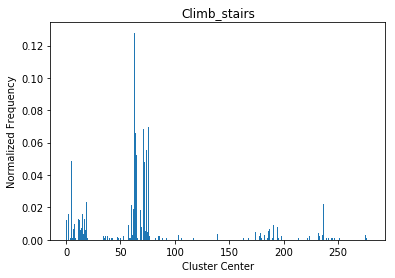

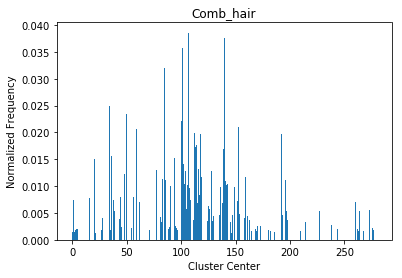

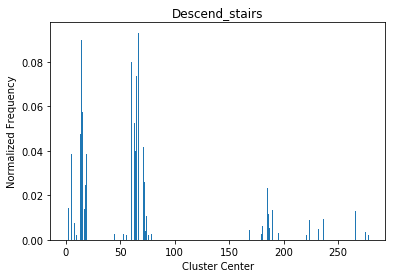

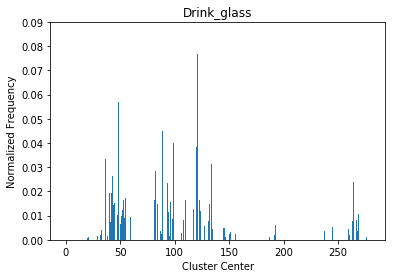

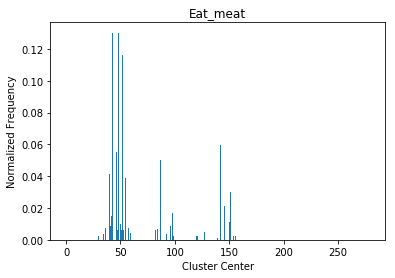

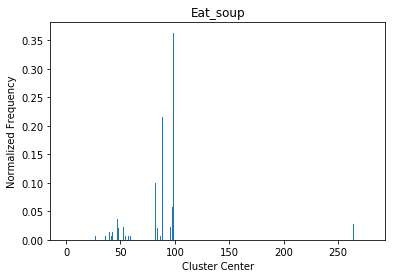

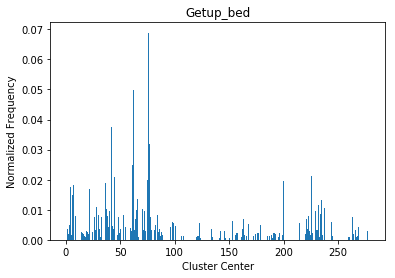

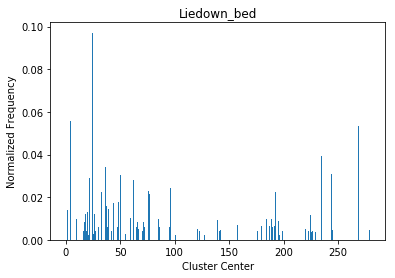

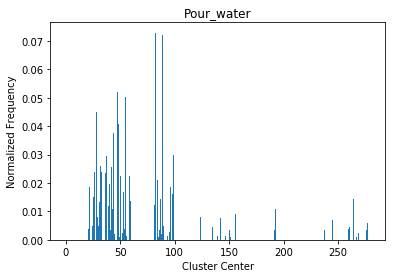

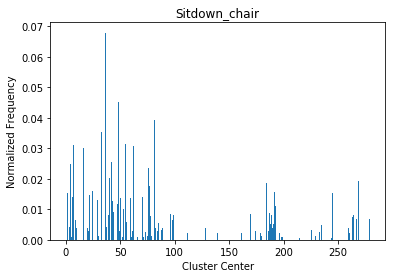

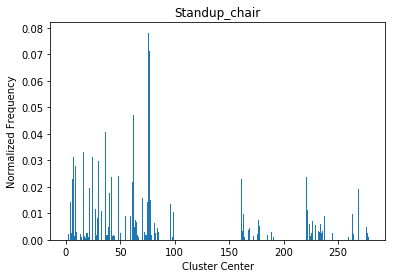

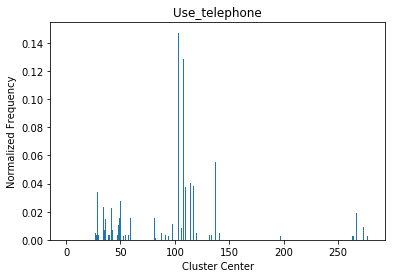

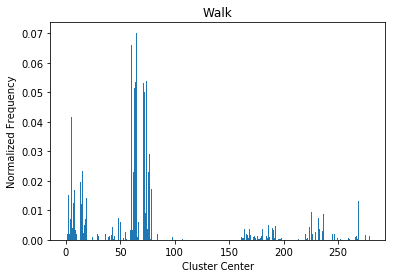

Finished Exporting Files


In [63]:
centers2 = hkmeans(chunks, lay1 = 14, lay2 = 20, siz = 64)

XvalidSequence = "64_14_20_321_"
save_path = 'C:/Users/worawich-win/Documents/GitHub/CS498AML-HW5/%s' %XvalidSequence
predict(frac3, frac2, frac1)

XvalidSequence = "64_14_20_213_"
save_path = 'C:/Users/worawich-win/Documents/GitHub/CS498AML-HW5/%s' %XvalidSequence
predict(frac2, frac1, frac3)

XvalidSequence = "64_14_20_132_"
save_path = 'C:/Users/worawich-win/Documents/GitHub/CS498AML-HW5/%s' %XvalidSequence
predict(frac1, frac3, frac2)

64 _14,10_ 200 , 800
Finished Data Preparations...
Finished Generating Training Histograms...
Finished Generating Testing Histograms...
Finished Predicting...
Accuracy:  64.74820143884892 %
Executed in --- 581.3272047042847 seconds ---


C:\Users\worawich-win\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


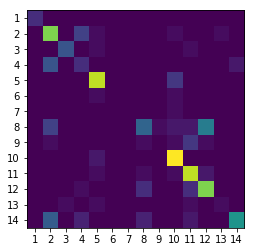

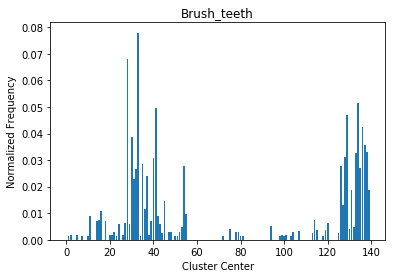

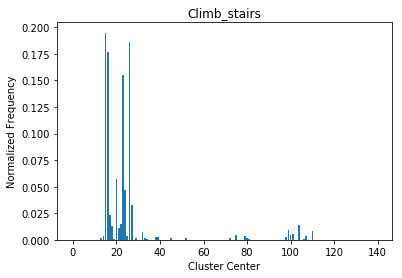

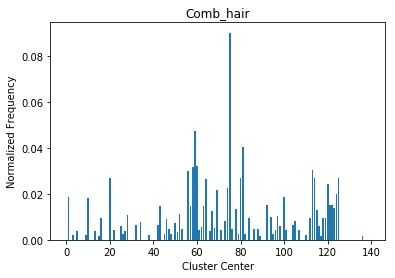

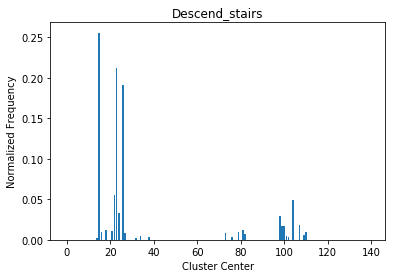

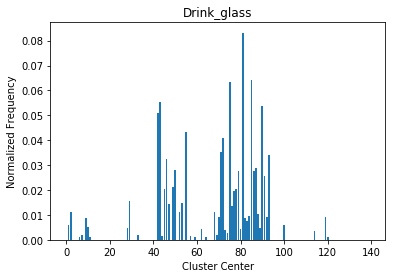

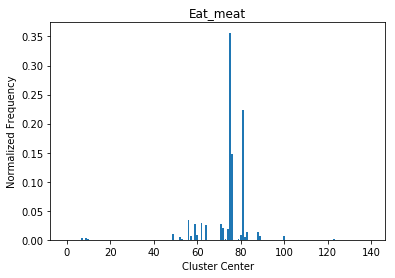

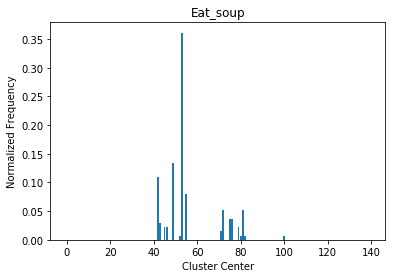

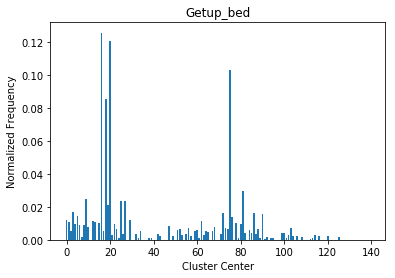

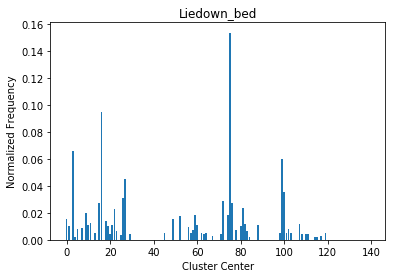

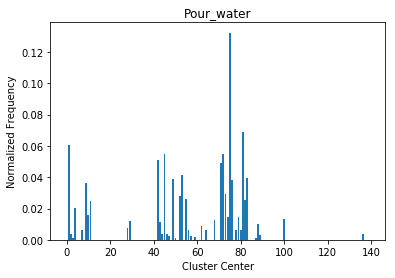

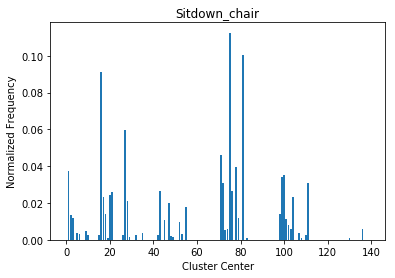

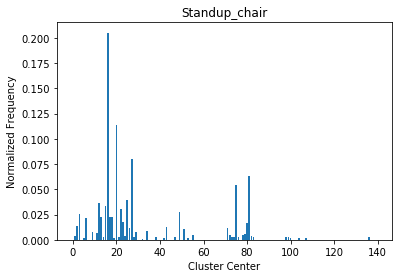

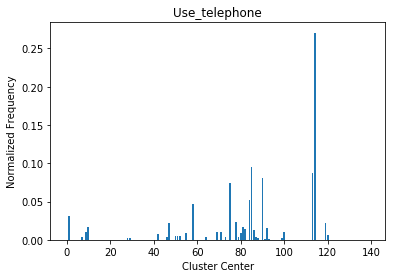

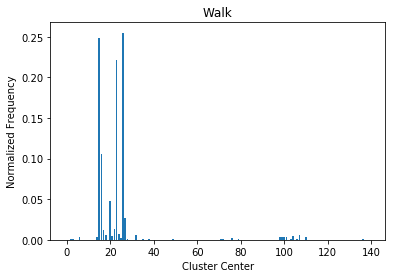

Finished Exporting Files


In [64]:
centers2 = hkmeans(chunks, lay1 = 10, lay2 = 14, siz = 64)

XvalidSequence = "64_10_14_321_"
save_path = 'C:/Users/worawich-win/Documents/GitHub/CS498AML-HW5/%s' %XvalidSequence
predict(frac3, frac2, frac1)